In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
""" %matplotlib inline
%config InlineBackend.figure_format = 'retina'"""

import warnings

from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as ss
import os
import pickle

from scipy.optimize import curve_fit

import statsmodels.formula.api as smf

from neurodsp.spectral import compute_spectrum
from fooof import FOOOF

""" import seaborn as sns
sns.set_style('whitegrid')"""

import matplotlib.pyplot as plt
#from matplotlib import cm, rc

from collections import Counter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/rr/tk8wmt7x4xlgzgmcy768y1rm0000gn/T/ipykernel_96139/737801025.py:21: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


### Read pickle files  - rat single knee results after removing outliers 

In [3]:
#loop through pickle results in folder

pickle_dir_taus = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_timescales.pickle'
pickle_dir_divs  = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_divs.pickle'
pickle_dir_cultures = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_cultures.pickle'


In [4]:
#load pickle files
with open(pickle_dir_taus, 'rb') as f:
    rat_taus = pickle.load(f)
    
with open(pickle_dir_divs, 'rb') as f:
    rat_divs = pickle.load(f)

with open(pickle_dir_cultures, 'rb') as f:
    rat_cults = pickle.load(f)

Text(0.5, 0, 'DIVS')

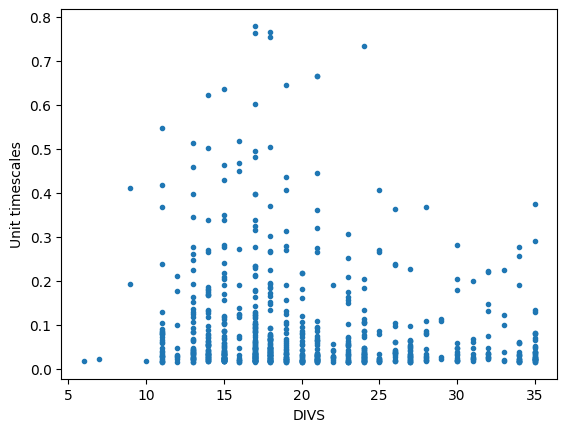

In [5]:
plt.plot(rat_divs, rat_taus, '.')
plt.ylabel("Unit timescales")
plt.xlabel("DIVS")

##### It looks like the early divs have very few timepoints after outlier removal

In [6]:

# Assuming you have 'divs' as your numpy array
unique_divs, divs_counts = np.unique(rat_divs, return_counts=True)

# Now, 'unique_divs' contains unique values in 'divs', and 'divs_counts' contains their respective counts
for div, count in zip(unique_divs, divs_counts):
    print(f"div: {div}, Count: {count}")

div: 6, Count: 1
div: 7, Count: 1
div: 9, Count: 2
div: 10, Count: 1
div: 11, Count: 29
div: 12, Count: 9
div: 13, Count: 44
div: 14, Count: 54
div: 15, Count: 70
div: 16, Count: 19
div: 17, Count: 92
div: 18, Count: 81
div: 19, Count: 40
div: 20, Count: 32
div: 21, Count: 42
div: 22, Count: 10
div: 23, Count: 30
div: 24, Count: 42
div: 25, Count: 14
div: 26, Count: 18
div: 27, Count: 26
div: 28, Count: 13
div: 29, Count: 4
div: 30, Count: 14
div: 31, Count: 10
div: 32, Count: 13
div: 33, Count: 6
div: 34, Count: 20
div: 35, Count: 33


#### Remove divs before DIV 11 - not enough datapoints

In [7]:

# Assuming you have 'divs' and 'taus' as your numpy arrays
threshold = 11  # Set your desired threshold value

# Create a mask to filter data points where divs are greater than or equal to the threshold
mask = (rat_divs >= threshold)

# Apply the mask to both 'divs' and 'taus' arrays
filtered_divs = rat_divs[mask]
filtered_taus = rat_taus[mask]

Text(0.5, 0, 'DIVS')

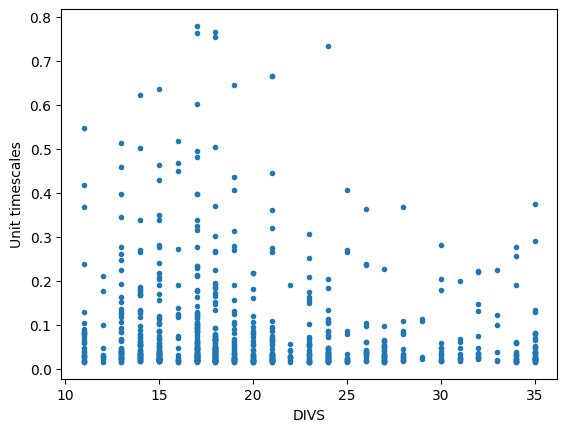

In [8]:
plt.plot(filtered_divs, filtered_taus, '.')
plt.ylabel("Unit timescales")
plt.xlabel("DIVS")

## Hypotheses fitting (for figure 2 for timescale dev paper)

In [9]:
def rsq(xdata, ydata, popt, f):
    
    #residual sum of squares
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    #total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared
    

In [10]:
def f_test(xdata, ydata, model0, model1, popt0, popt1, p0, p1):

    yfit0 = model0(xdata, *popt0)
    yfit1 = model1(xdata, *popt1)

    ssq0 = ((yfit0-ydata)**2).sum()
    ssq1 = ((yfit1-ydata)**2).sum()
    
    param_diff = p1 - p0
    print(param_diff)
    
    if param_diff == 0:
        df_0 = len(xdata) - p0
        df_1 = len(xdata) - p1
        f_ratio = ssq1/ssq0
        p = 1 - ss.f.cdf(f_ratio, df_0, df_1)
    else:
        df = len(xdata) - p1
        print("df", df)
        f_ratio = ((ssq0 - ssq1) / param_diff) / (ssq1 / df)
        p = 1 - ss.f.cdf(f_ratio, param_diff, df)

    return f_ratio, p

In [11]:
# Define the Gaussian function
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 
# Define the sigmoid function
def sigmoid(x, A, B, C, D):
    return A / (1 + np.exp(-C * (x - B))) + D

# Define the horizontal line function (constant)
def horizontal_line(x, A):
    return A

In [12]:
def fit_hyp(divs, taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid):
    
    
    # Fit the Gaussian function to your data
    params_gaussian, _ = curve_fit(gaussian, divs, taus, p0=guess_gaussian, bounds=bounds_gaussian, maxfev=2000)

    # Fit the sigmoid function to your data
    params_sigmoid, _ = curve_fit(sigmoid, divs, taus, p0=guess_sigmoid,bounds=bounds_sigmoid, maxfev=2000)

    # Fit the horizontal line to your data
    params_horizontal_line, _ = curve_fit(horizontal_line, divs, taus)


    return params_horizontal_line, params_sigmoid, params_gaussian

In [13]:
def plt_hyp(divs, taus, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None ):
    
    # Create a range of x values for plotting
    x_fit = np.linspace(min(divs), max(divs), 100)

    # Calculate the corresponding y values using the fitted parameters for each function
    y_fit_gaussian = gaussian(x_fit, *params_gaussian)
    y_fit_sigmoid = sigmoid(x_fit, *params_sigmoid)
    y_fit_horizontal_line = horizontal_line(x_fit, params_horizontal_line[0])

    # Plot the data and the fitted functions
    plt.figure(figsize =  (6,5))
    # Create the scatter plot of the data
    plt.plot(divs, taus, '.', color = "dimgrey")
    #plt.ylabel("Log(timescales)", size = 18)
    #plt.xlabel("Days ", size = 18)
    plt.xticks(size = 13)
    plt.yticks(size = 13)

    plt.axhline(y=params_horizontal_line[0], xmin = 0.04, xmax = 0.98, color='#FDAE61', linestyle='-.', linewidth=5,dashes=(5,2))
    plt.plot(x_fit, y_fit_sigmoid, '-.', color='#2D7BB6', linewidth=5, dashes=(4,2))
    plt.plot(x_fit, y_fit_gaussian, '-.',color='#D7191D', linewidth=5, dashes=(2, 2))
    
    if ylim:
        plt.ylim(ylim[0],ylim[1])

    
    """
    days_pn = ['6', '11', '16', '21','26','31']
    
    locs, labels = plt.xticks()
    print(locs)
    labels = days_pn
    plt.xticks(locs[1:-1], labels)"""
    plt.show()

### Linear version

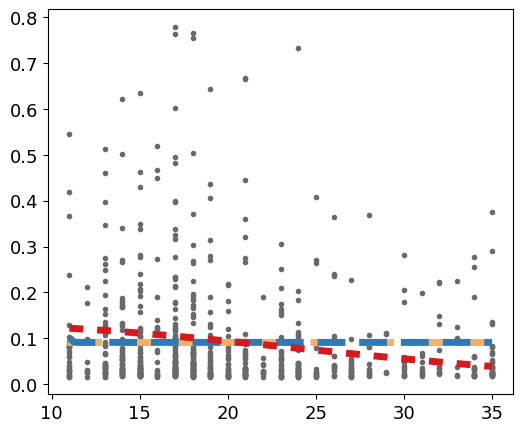

In [28]:
#guess gaussian - [initial_A, initial_mu, initial_sigma]
#bounds gaussian - ([min_A, min_mu, min_sigma], [max_A, max_mu, max_sigma])
#A: Amplitude
#mu: Mean (center)
#sigms: Standard Deviation
    

# Guess and bounds for Gaussian fit
guess_gaussian = [0.4, 17, 5]
bounds_gaussian = ([0.13, 0, 5], [10, 17, 20])

#guess sigmoid - [initial_A, initial_x0, initial_k, initial_b]
#bounds sigmoid  - ([min_A, min_x0, min_k, min_b], [max_A, max_x0, max_k, max_b])
#A: Amplitude
#x0: Midpoint
#k: Slope
#b: Offset

# Guess and bounds for Sigmoid fit
guess_sigmoid = (2.0, 10.0, 1.0, 1.0)
bounds_sigmoid = ([-np.inf, 10, -np.inf, -np.inf], [np.inf, 30, np.inf, np.inf])

params_horizontal_line, params_sigmoid, params_gaussian = fit_hyp(filtered_divs, filtered_taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(filtered_divs, filtered_taus, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None )

### Logged version

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


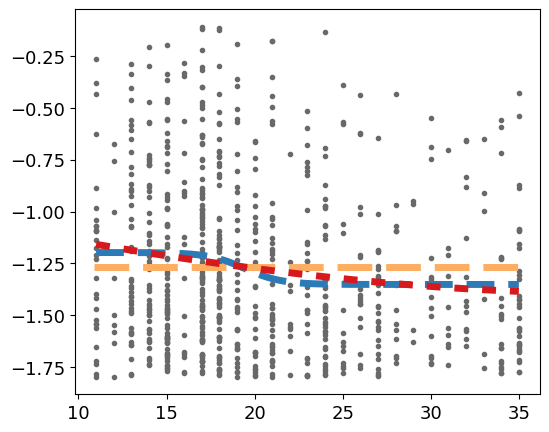

In [29]:
filtered_taus_log = np.log10(filtered_taus)

# Guess and bounds for Gaussian fit
guess_gaussian = [0.6, 15, 0.5
                 ]
bounds_gaussian = ([0.2, 10,0], [0.9,20, 10])
bounds_gaussian = ([-np.inf, -np.inf,-np.inf], [np.inf,np.inf, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 15.0, 3.0, 1.0)
bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_log, params_sigmoid_log, params_gaussian_log = fit_hyp(filtered_divs, filtered_taus_log, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(filtered_divs, filtered_taus_log, params_horizontal_line_log, params_sigmoid_log, params_gaussian_log, ylim=None )

### Normalized divs linear 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


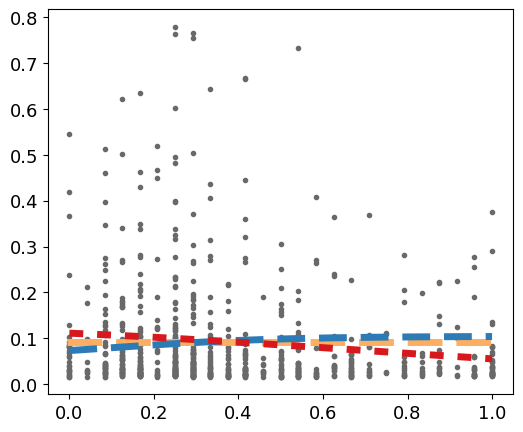

In [30]:

# Normalize the divs data to the range [0, 1]
divs_normalized = (filtered_divs - filtered_divs.min()) / (filtered_divs.max() - filtered_divs.min())

# Guess and bounds for Gaussian fit
guess_gaussian = [0.1, 0.4, 0.25]
bounds_gaussian = ([0.05, 0.2, 0], [10, 0.5, 0.3])
bounds_gaussian = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
#guess sigmoid - [initial_A, initial_x0, initial_k, initial_b]
#bounds sigmoid  - ([min_A, min_x0, min_k, min_b], [max_A, max_x0, max_k, max_b])
#A: Amplitude
#x0: Midpoint
#k: Slope
#b: Offset

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.1, 0.2, 6, 0.5)
bounds_sigmoid = ([0.05, 0.1, 5, -np.inf], [np.inf, 0.6, np.inf, np.inf])

params_horizontal_line_norm, params_sigmoid_norm, params_gaussian_norm = fit_hyp(divs_normalized, filtered_taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(divs_normalized, filtered_taus, params_horizontal_line_norm, params_sigmoid_norm, params_gaussian_norm, ylim=None )


### Compute rsqs for fits - log version

In [31]:
#get r-squared values

rsqs_rat_h0 = rsq(filtered_divs,  filtered_taus_log, params_horizontal_line_log, horizontal_line) 
rsqs_rat_h1 = rsq(filtered_divs,  filtered_taus_log, params_sigmoid_log, sigmoid) 
rsqs_rat_h2 = rsq(filtered_divs,  filtered_taus_log, params_gaussian_log, gaussian) 

print("rsq rat h0:", rsqs_rat_h0)
print("rsq rat h1:", rsqs_rat_h1)
print("rsq rat h2:", rsqs_rat_h2)

rsq rat h0: 0.0
rsq rat h1: 0.026266138744954537
rsq rat h2: 0.023134263021238888


### f-tests

In [32]:

#f-tests
f_test_h0_h1 = f_test(filtered_divs, filtered_taus_log, horizontal_line, sigmoid,
                      params_horizontal_line_log, params_sigmoid_log, 1, 4)
f_test_h0_h2 = f_test(filtered_divs, filtered_taus_log, horizontal_line, gaussian, 
                      params_horizontal_line_log, params_gaussian_log,1,3)
f_test_h2_h1 = f_test(filtered_divs, filtered_taus_log, gaussian, sigmoid, 
                      params_gaussian_log, params_sigmoid_log,3,4)

print("f_test rat h0 vs h1:", f_test_h0_h1)
print("f_test rat h0 vs h2:", f_test_h0_h2)
print("f_test rat h1 vs h2:", f_test_h2_h1)

3
df 761
2
df 762
1
df 761
f_test rat h0 vs h1: (6.842571801959368, 0.00014928831312988056)
f_test rat h0 vs h2: (9.022892171806872, 0.00013399488673415672)
f_test rat h1 vs h2: (2.4476476792905917, 0.11811685643293923)


## Mean analysis

### Get mean days and timescales

In [33]:
def get_mean_std_recday (taus, divs):
    days = sorted(set(divs))
    all_indices = []
    days_taus = []
    mean_taus = []
    std_taus = []

    #get indices for each day

    for d in days:
   
        indices = [i for i, x in enumerate(divs) if x == d]

        
        all_indices.append(indices)
        #get taus for those indices
        day_taus = taus[indices]
        days_taus.append(day_taus)
        #get means and stds
        mean_taus.append(np.mean(day_taus))
        std_taus.append(np.std(day_taus))
        
    return [days, all_indices, days_taus, mean_taus, std_taus]

In [34]:
days, all_indices,days_taus_filt, mean_taus_filt, std_filt = get_mean_std_recday(filtered_taus, filtered_divs)

Text(0.5, 1.0, 'Mean day taus')

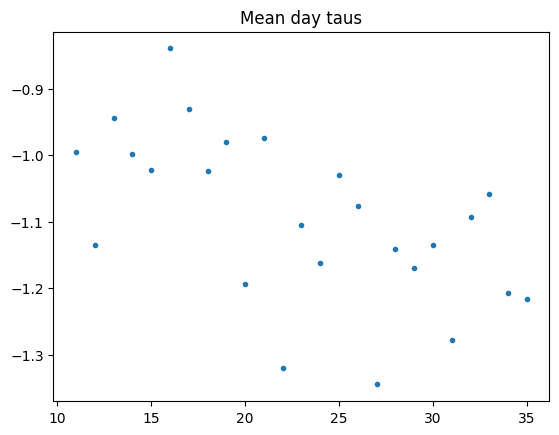

In [35]:
#plot the mean
plt.plot(days, np.log10(mean_taus_filt), '.')
plt.title("Mean day taus")

### Fit the mean 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


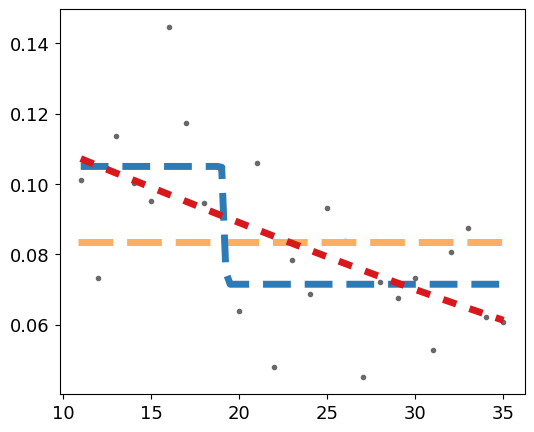

In [36]:
#Linear

# Guess and bounds for Gaussian fit
guess_gaussian = [0.6, 15, 0.5
                 ]
bounds_gaussian = ([0.2, 10,0], [0.9,20, 10])
bounds_gaussian = ([-np.inf, -np.inf,-np.inf], [np.inf,np.inf, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 15.0, 0.12, 0.06)
bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean = fit_hyp(days, mean_taus_filt, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days,  mean_taus_filt, params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean, ylim=None )


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


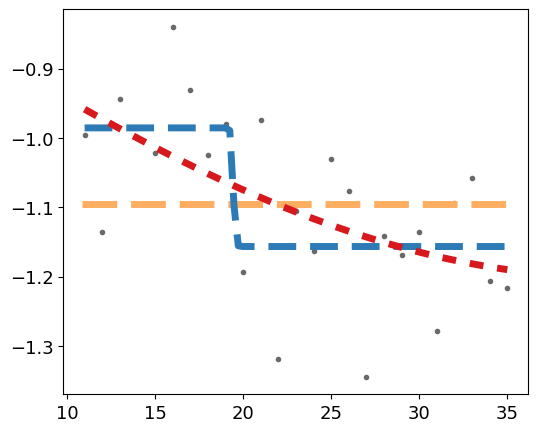

In [37]:
#Log

# Guess and bounds for Gaussian fit
guess_gaussian = [0.6, 15, 0.5
                 ]
bounds_gaussian = ([0.2, 10,0], [0.9,20, 10])
bounds_gaussian = ([-np.inf, -np.inf,-np.inf], [np.inf,np.inf, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 15.0, -1.0, -1.25)
bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_mean_log, params_sigmoid_mean_log, params_gaussian_mean_log = fit_hyp(days, np.log10(mean_taus_filt), guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days, np.log10(mean_taus_filt), params_horizontal_line_mean_log, params_sigmoid_mean_log,params_gaussian_mean_log, ylim=None )


### Calculate rsq for mean

In [38]:
#get r-squared values

rsqs_rat_h0 = rsq(days,  np.log10(mean_taus_filt),params_horizontal_line_mean_log, horizontal_line) 
rsqs_rat_h1 = rsq(days,  np.log10(mean_taus_filt),  params_sigmoid_mean_log, sigmoid) 
rsqs_rat_h2 = rsq(days,  np.log10(mean_taus_filt), params_gaussian_mean_log, gaussian) 

print("rsq rat h0:", rsqs_rat_h0)
print("rsq rat h1:", rsqs_rat_h1)
print("rsq rat h2:", rsqs_rat_h2)

rsq rat h0: 0.0
rsq rat h1: 0.4475037890124409
rsq rat h2: 0.3331052192558781


### f-tests for mean

In [39]:

#f-tests
f_test_h0_h1 = f_test(days, np.log10(mean_taus_filt), horizontal_line, sigmoid,
                      params_horizontal_line_mean_log, params_sigmoid_mean_log, 1, 4)
f_test_h0_h2 = f_test(days, np.log10(mean_taus_filt), horizontal_line, gaussian, 
                      params_horizontal_line_mean_log, params_gaussian_mean_log,1,3)
f_test_h2_h1 = f_test(days, np.log10(mean_taus_filt), gaussian, sigmoid, 
                      params_gaussian_mean_log, params_sigmoid_mean_log,3,4)

print("f_test rat h0 vs h1:", f_test_h0_h1)
print("f_test rat h0 vs h2:", f_test_h0_h2)
print("f_test rat h1 vs h2:", f_test_h2_h1)

3
df 21
2
df 22
1
df 21
f_test rat h0 vs h1: (5.669770146455582, 0.005244212131310544)
f_test rat h0 vs h2: (5.4943561077598915, 0.011604608785157788)
f_test rat h1 vs h2: (4.348210751696747, 0.04943778052513015)


### Reviewers- number of cells across development

Text(0.5, 1.0, 'Mean day taus')

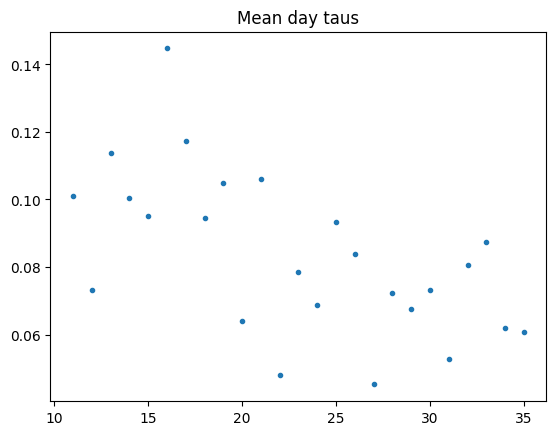

In [43]:
#plot the mean
plt.plot(days, mean_taus_filt, '.')
plt.title("Mean day taus")

In [46]:
len(filtered_taus)

765

In [47]:
filtered_divs

array([18, 18, 18, 18, 19, 23, 23, 23, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 32, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 12, 12, 12, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 34, 35, 35, 35, 35, 35, 35, 35,
       13, 13, 13, 18, 21, 21, 27, 29, 31, 32, 32, 34, 35, 35, 21, 21, 21,
       21, 23, 23, 23, 23, 23, 25, 25, 25, 27, 27, 27, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 17, 17, 17, 17, 17, 17, 17, 17, 19, 19, 19, 19,
       21, 33, 35, 35, 11, 13, 13, 13, 13, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 22, 27, 29,
       34, 34, 35, 35, 13, 13, 13, 13, 18, 18, 18, 24, 24, 27, 27, 31, 31,
       31, 31, 33, 34, 34, 34, 35, 15, 17, 21, 20, 26, 26, 28, 30, 30, 34,
       14, 14, 14, 16, 23, 23, 26, 26, 28, 28, 28, 31, 31, 11, 11, 11, 11,
       11, 12, 13, 13, 14, 14, 14, 14, 14, 15, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18

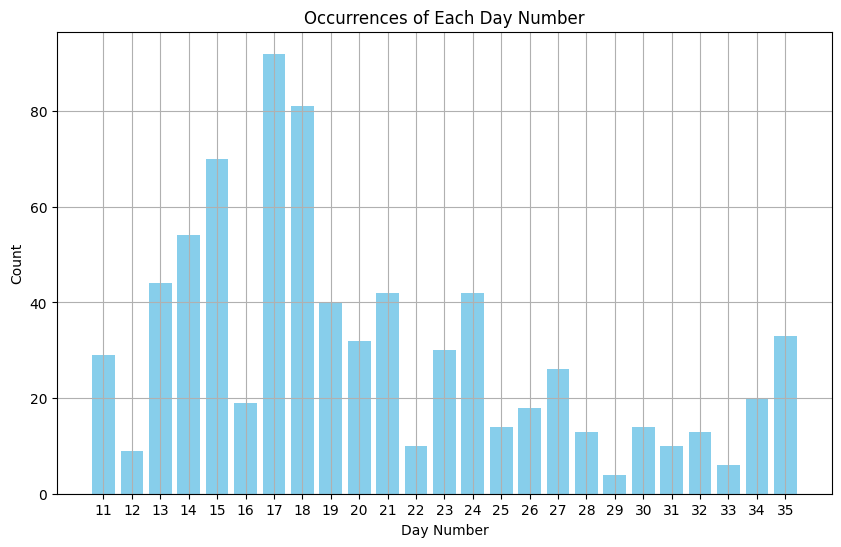

In [42]:
# Count the occurrences of each day number
day_counts = Counter(filtered_divs)

# Separate the day numbers and their counts for plotting
day_numbers = list(day_counts.keys())
counts = list(day_counts.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(day_numbers, counts, color='skyblue')
plt.xlabel('Day Number')
plt.ylabel('Count')
plt.title('Occurrences of Each Day Number')
plt.xticks(day_numbers)  # Ensure all day numbers are shown on the x-axis
plt.grid(True)
plt.show()
#plot mean tau